## Stereotypes in online pornography

#### Questions:

1. To what extent stereotypes present in online pornography? (word emb)​
2. How popular are they? ​
3. Grammatical analysis
4. What is the connection between them? (network)​
5. How does this change over time? (time series)

Problems:
Word embedding model is too large/slow to run on laptop. Only a subset of data is used for now. This needs to be run on HPC.


In [2]:
import pandas as pd
from collections import Counter
import src.models.embeddings as embeddings
import src.utils.helpers as helpers
import src.data.clean as clean

import seaborn as sns
import matplotlib.pyplot as plt
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

/home/olga/Documents/eur-porntypes/stereotype-map/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Tag analysis


In [3]:
# process original data
columns_to_read = [
    "url",
    "title",
    "categories",
    "date",
    "views",
    "upvotes",
    "downvotes",
    "production",
    "comments",
    "actors",
]

df = pd.read_csv("data/raw/porn-with-dates-2022.csv", usecols=columns_to_read)
df.head(5)

,url,title,categories,date,views,upvotes,downvotes,production,comments,actors
0,https://www.pornhub.com/view_video.php?viewkey...,Cute teen gloryhole handjob,"['Babe', 'Big Tits', 'Brunette', 'HD Porn', 'H...",2018-11-01,37012,78,22,professional,joesenetto 2 months ago In the name of the Rep...,NaN
1,https://www.pornhub.com/view_video.php?viewkey...,Realy Nice Step Mom Angie Gives Titjob Good Yo...,"['Blowjob', 'HD Porn', 'Hardcore', 'MILF', 'Ro...",2018-12-01,2083844,6318,174,professional,AStrayPornCritic 1 month ago Discussion- 2/10T...,NaN
2,https://www.pornhub.com/view_video.php?viewkey...,Step Mom´s gift for son - pov,"['Big Tits', 'Brunette', 'Cumshot', 'HD Porn',...",2018-07-01,22388562,64554,28325,professional,Leopold_Butters 6 months ago You ever had a mo...,"Alex Adams,Shay Evans"
3,https://www.pornhub.com/view_video.php?viewkey...,Baltimore Street Hooker Creampie,"['Amateur', 'Anal', 'Creampie', 'HD Porn', 'Ha...",2018-01-01,348440,1120,124,homemade,MusicSexBliss 1 year ago Nothing hotter that f...,NaN
4,https://www.pornhub.com/view_video.php?viewkey...,Cute Blonde and Brunette Pleasure Each Other,"['Amateur', 'Blonde', 'Brunette', 'Fingering',...",2018-12-01,105513,344,15,professional,deborahedwards947 3 weeks ago Want to see me s...,Alexis Brill


In [4]:
# Create 'tags' column from categories
df["tags"] = df["categories"].apply(clean.extract_tags)
df = df.drop(columns=["categories"])
# Remove a specific tag from the "tags" column
df["tags"] = df["tags"].apply(clean.remove_tag, tag_to_remove="HD Porn")
# confirm it is a list
# df.tags.apply(lambda tag_list: isinstance(tag_list, list))

In [5]:
# flatten out tags
df_flat_tag = clean.flatten_tags(df.tags)
# number of unique hashtags
df_flat_tag["tag"].unique().size

108

In [6]:
# count the number of each hashtag
popular_tags_set = clean.get_popular_tags(df_flat_tag)

# make a new column with only the popular tags
df["popular_tags"] = df.tags.apply(
    lambda tag_list: clean.filter_popular_tags(tag_list, popular_tags_set)
)
# replace url with identifier
df["url"] = df.url.apply(lambda x: helpers.extract_and_create_unique_id(x, length=11))

# drop rows without popular tag
df_popular_tags = df.loc[df.popular_tags.apply(lambda tag_list: tag_list != [])]
df_tags_vector = df_popular_tags.loc[:, ["popular_tags"]]

for tag in popular_tags_set:
    # make columns to encode presence of hashtags
    df_tags_vector["{}".format(tag)] = df_tags_vector.popular_tags.apply(
        lambda tag_list: int(tag in tag_list)
    )
# create a matrix of tags
tag_matrix = df_tags_vector.drop("popular_tags", axis=1)

In [7]:
tag_matrix.head(5)

,Toys,MILF,Exclusive,Babe,Teen,Reality,Pornstar,Interracial,Hardcore,Lesbian,...,Public,Threesome,Blowjob,Verified Amateurs,Amateur,Blonde,Brunette,Big Ass,POV,Cumshot
0,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,1,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
2,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,1
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
4,0,0,0,0,1,0,1,0,0,1,...,0,0,0,0,1,1,1,0,0,0


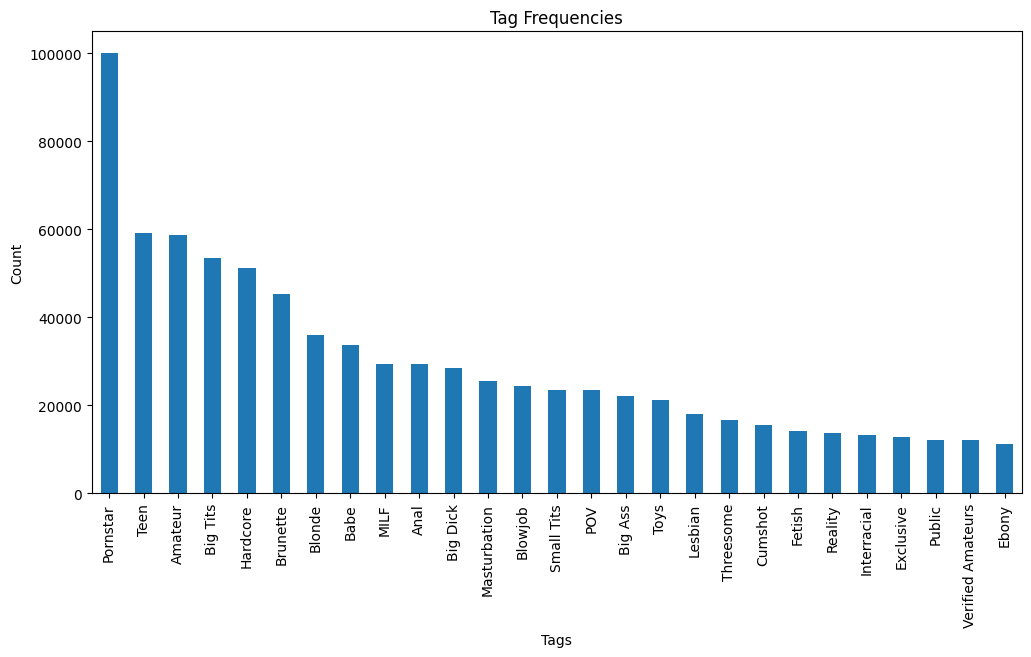

In [8]:
tag_counts = tag_matrix.sum().sort_values(ascending=False)
tag_counts.plot(kind="bar", figsize=(12, 6))
plt.title("Tag Frequencies")
plt.xlabel("Tags")
plt.ylabel("Count")
plt.xticks(rotation=90)
output_plot_path = "plots/tag_frequency_distribution.png"
plt.savefig(output_plot_path, bbox_inches="tight")
plt.show()

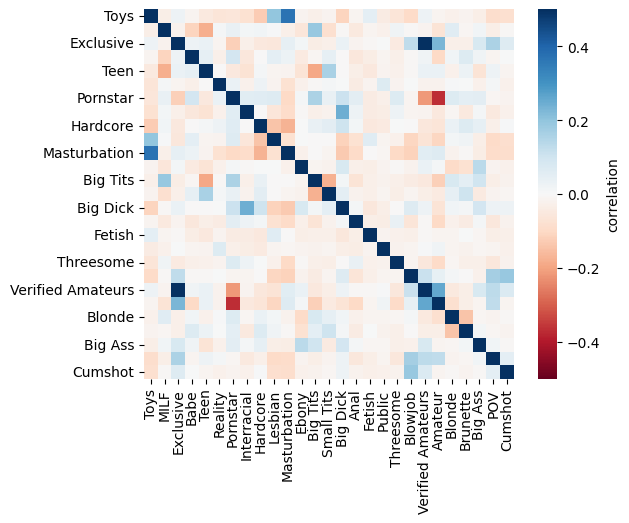

In [9]:
# correlation matrix
correlations = tag_matrix.corr()

sns.heatmap(
    correlations,
    cmap="RdBu",
    vmin=-0.5,
    vmax=0.5,
    square=True,
    cbar_kws={"label": "correlation"},
)
plt.savefig("plots/tag_correlation.png")

In [10]:
# Extract year from date
df["year"] = pd.to_datetime(df["date"]).dt.year

# Explode the popular_tags list so each tag gets its own row
df_exploded = df.explode("popular_tags")

# Group by year and tag, count occurrences
tag_counts = df_exploded.groupby(["year", "popular_tags"]).size().unstack(fill_value=0)

# Normalize counts to get frequencies
tag_frequencies = tag_counts.div(tag_counts.sum(axis=1), axis=0)


In [11]:
tag_frequencies.head(5)

popular_tags,Amateur,Anal,Babe,Big Ass,Big Dick,Big Tits,Blonde,Blowjob,Brunette,Cumshot,...,Masturbation,POV,Pornstar,Public,Reality,Small Tits,Teen,Threesome,Toys,Verified Amateurs
year,,,,,,,,,,,,,,,,,,,,,
2008,0.227119,0.039322,0.015593,0.016271,0.006102,0.058983,0.075932,0.026441,0.082712,0.021017,...,0.065085,0.017627,0.061017,0.018305,0.015593,0.001356,0.025085,0.030508,0.032542,0.000000
2009,0.079969,0.060879,0.024279,0.013943,0.010579,0.086616,0.056096,0.018158,0.060149,0.016091,...,0.036276,0.024927,0.133674,0.009444,0.035141,0.003040,0.053907,0.020266,0.030723,0.000000
2010,0.080613,0.077626,0.005282,0.018906,0.013296,0.096423,0.047137,0.003096,0.079593,0.010127,...,0.043640,0.021856,0.127532,0.013405,0.038759,0.053184,0.055333,0.015700,0.039997,0.000255
2011,0.078073,0.056354,0.016506,0.027279,0.024036,0.061392,0.041179,0.014885,0.040484,0.010599,...,0.031681,0.022819,0.189274,0.021198,0.037472,0.010946,0.079347,0.025773,0.034635,0.000232
2012,0.103738,0.053224,0.027778,0.020610,0.020439,0.067181,0.038992,0.023937,0.035357,0.009156,...,0.026749,0.022188,0.162243,0.020267,0.017044,0.013957,0.087551,0.031310,0.027332,0.000137


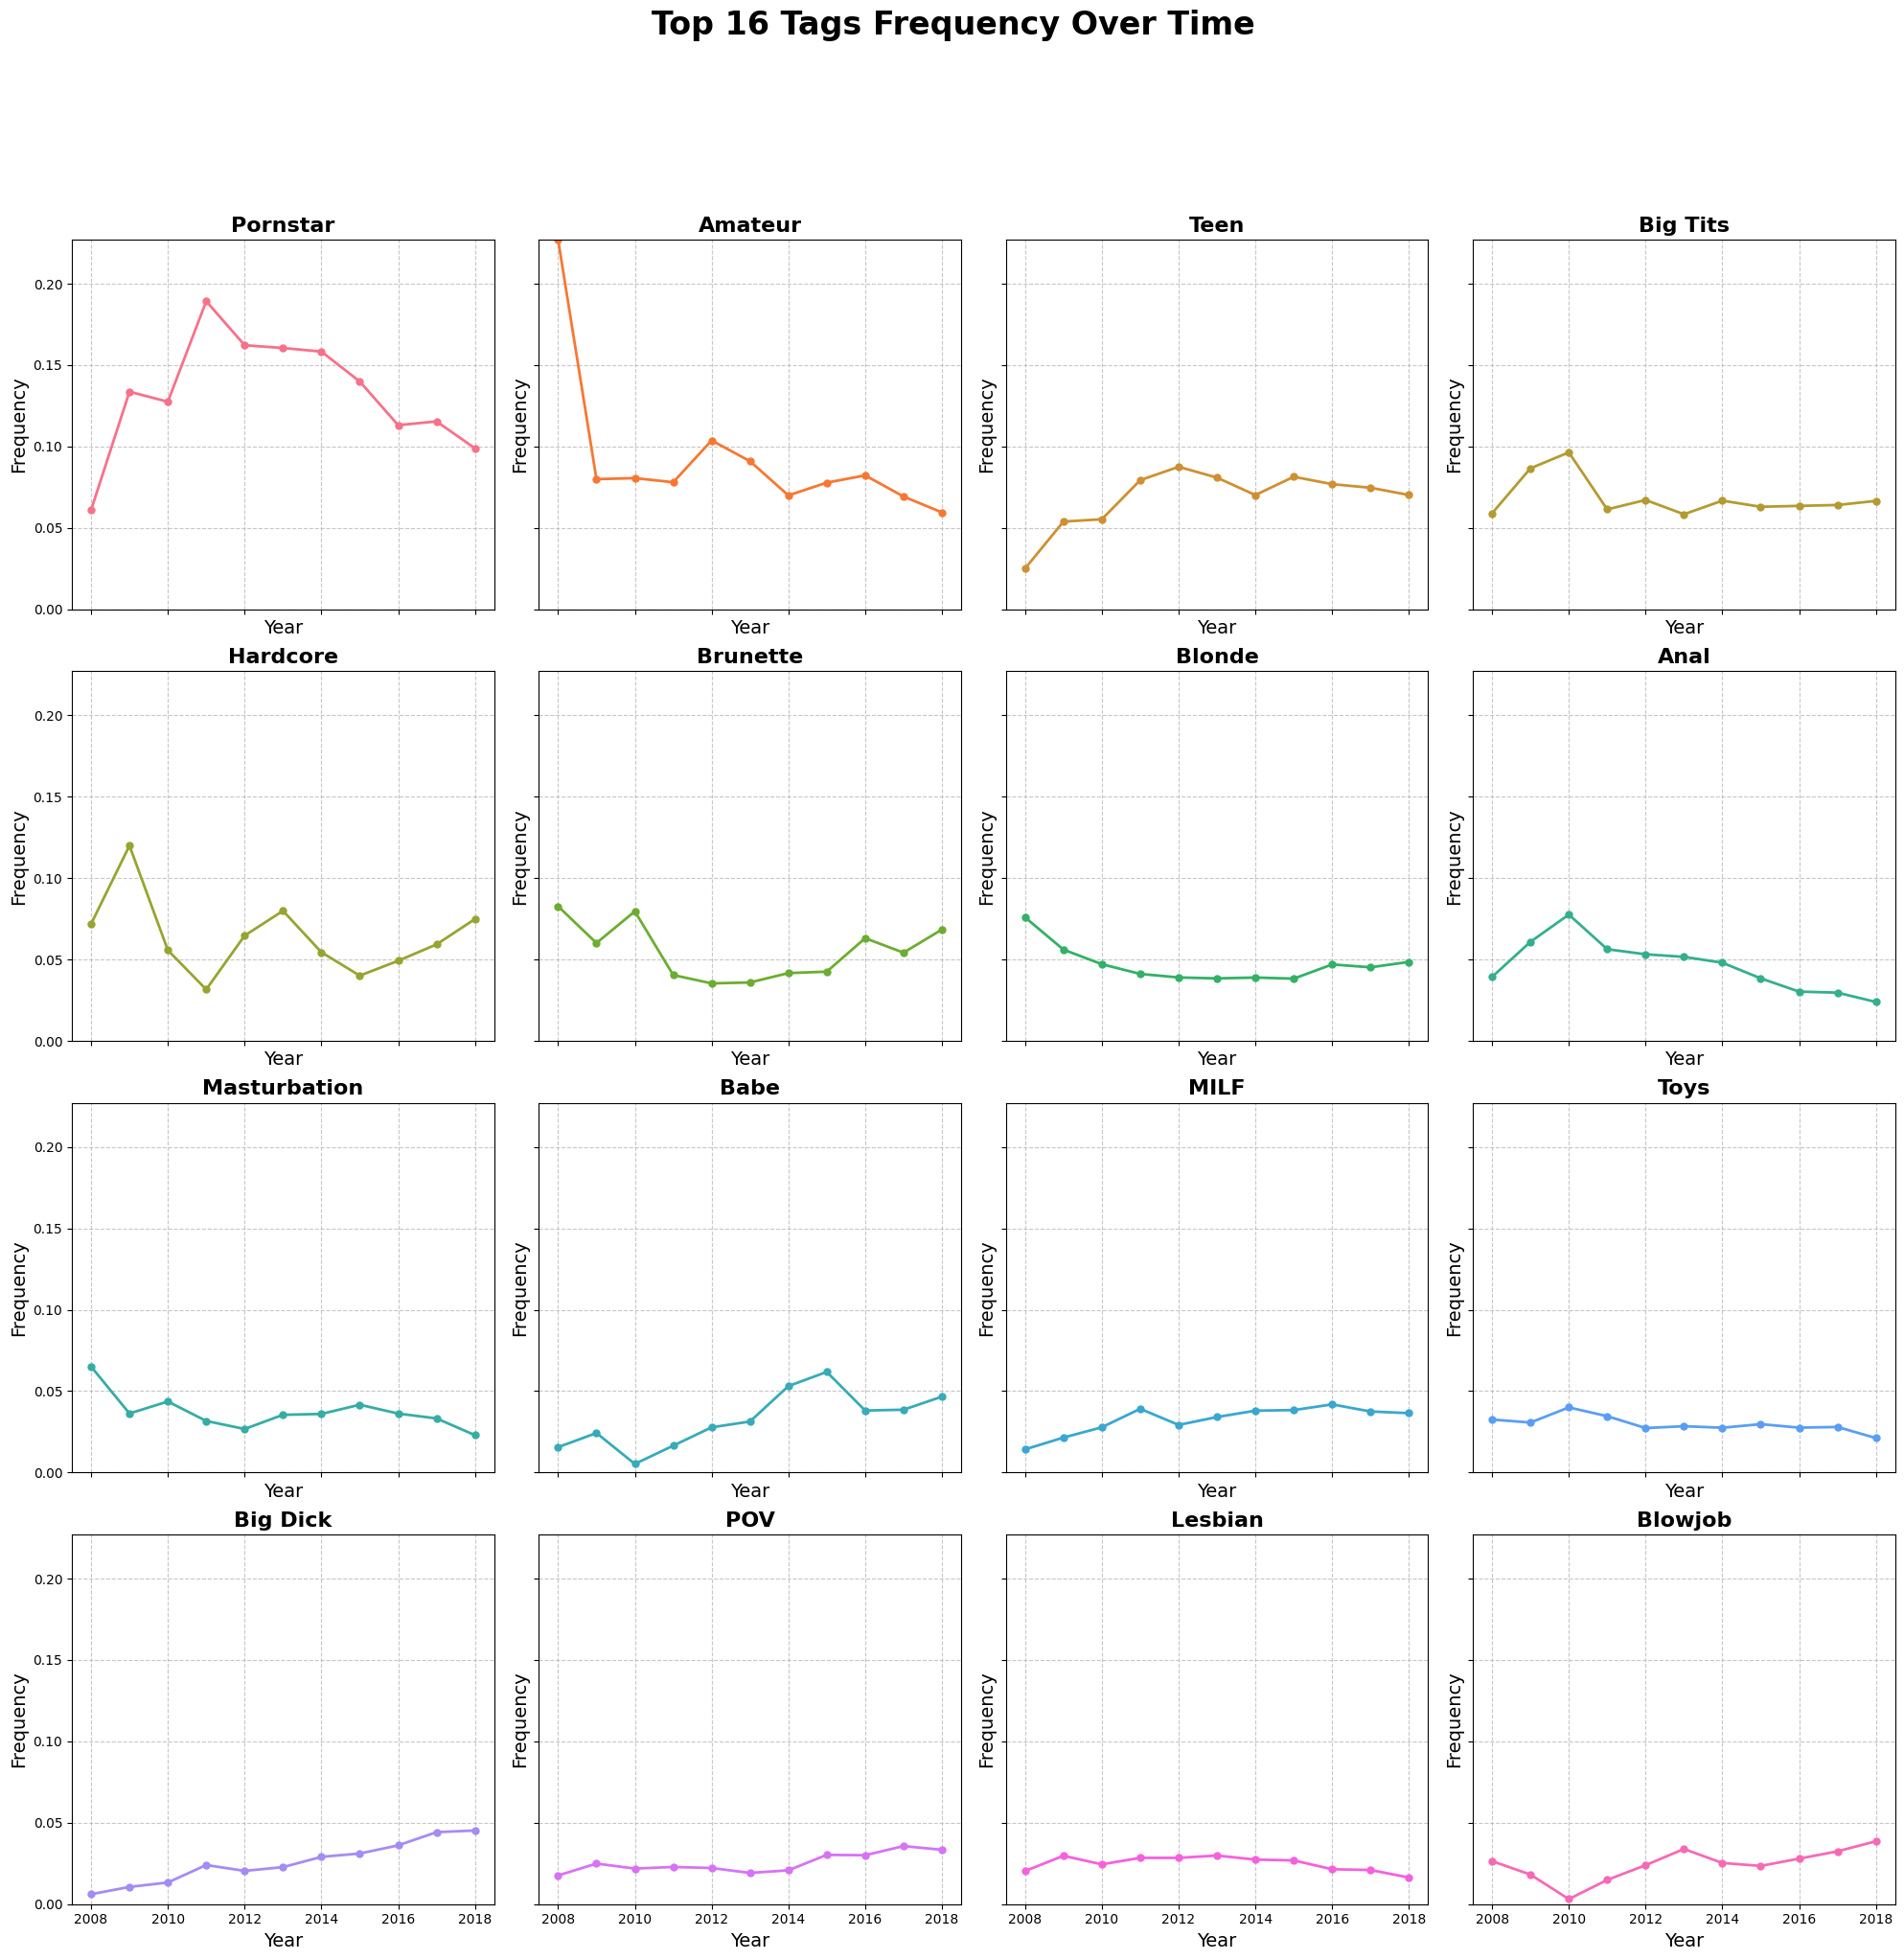

In [12]:
top_tags = tag_frequencies.sum().nlargest(16).index  # Choose top 16 tags
fig, axes = plt.subplots(4, 4, figsize=(20, 20), sharex=True, sharey=True)
axes = axes.flatten()

# Set a color palette
colors = sns.color_palette("husl", len(top_tags))

for i, tag in enumerate(top_tags):
    axes[i].plot(
        tag_frequencies.index,
        tag_frequencies[tag],
        color=colors[i],
        linewidth=2,
        marker="o",
        markersize=5,
    )
    axes[i].set_title(tag, fontsize=16, fontweight="bold")
    axes[i].set_ylim(0, tag_frequencies[top_tags].max().max())
    axes[i].set_xlabel("Year", fontsize=14)
    axes[i].set_ylabel("Frequency", fontsize=14)
    axes[i].grid(
        True, linestyle="--", alpha=0.7
    )  # Add grid lines for better readability

# Adjust layout and aesthetics
plt.suptitle("Top 16 Tags Frequency Over Time", fontsize=24, fontweight="bold", y=1.02)
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust the top to make room for the title
output_plot_path = "plots/top_16_tags_frequency_distribution_time.png"
plt.savefig(output_plot_path, bbox_inches="tight")
plt.show()

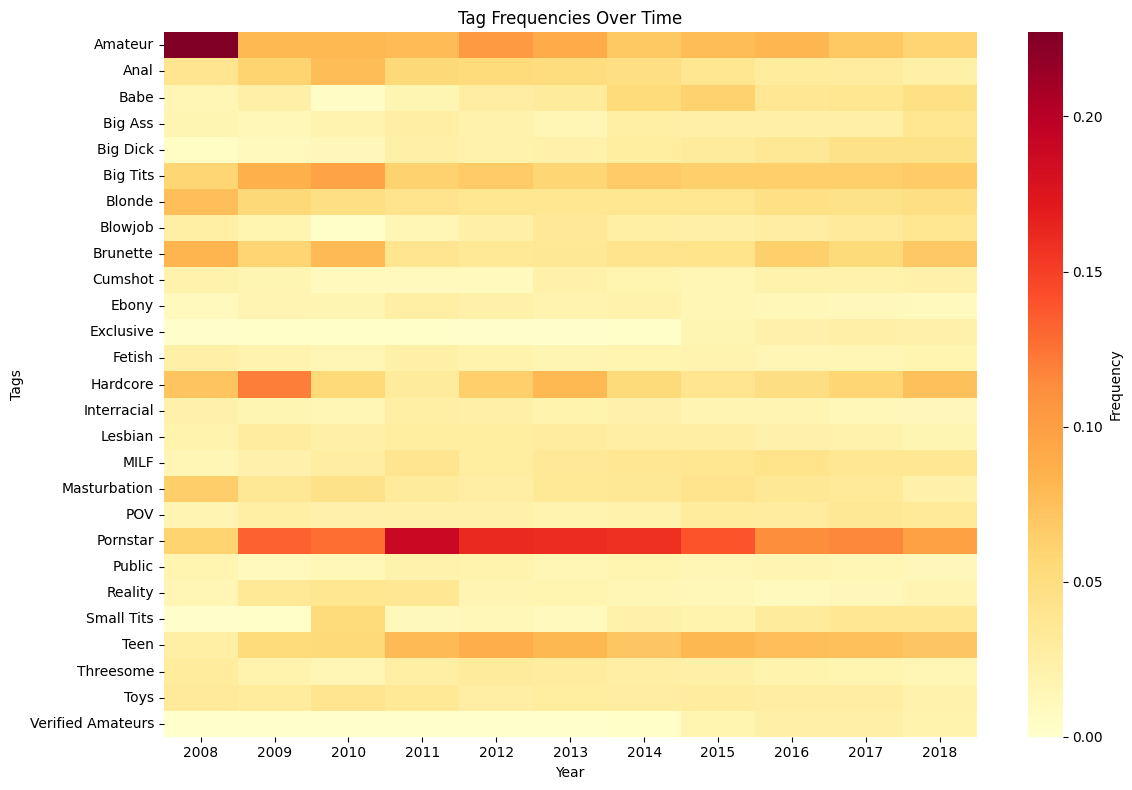

In [13]:
plt.figure(figsize=(12, 8))
sns.heatmap(tag_frequencies.T, cmap="YlOrRd", cbar_kws={"label": "Frequency"})
plt.title("Tag Frequencies Over Time")
plt.xlabel("Year")
plt.ylabel("Tags")
plt.tight_layout()
output_plot_path = "plots/tag_frequency_time.png"
plt.savefig(output_plot_path, bbox_inches="tight")
plt.show()

### 2. Title analyses


In [ ]:
# TODO CHECK why embeddings.clean_tokenize_and_stem does not remove all digits and non english characters?

#### Find most common words in titles


[nltk_data] Downloading package stopwords to /home/olga/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


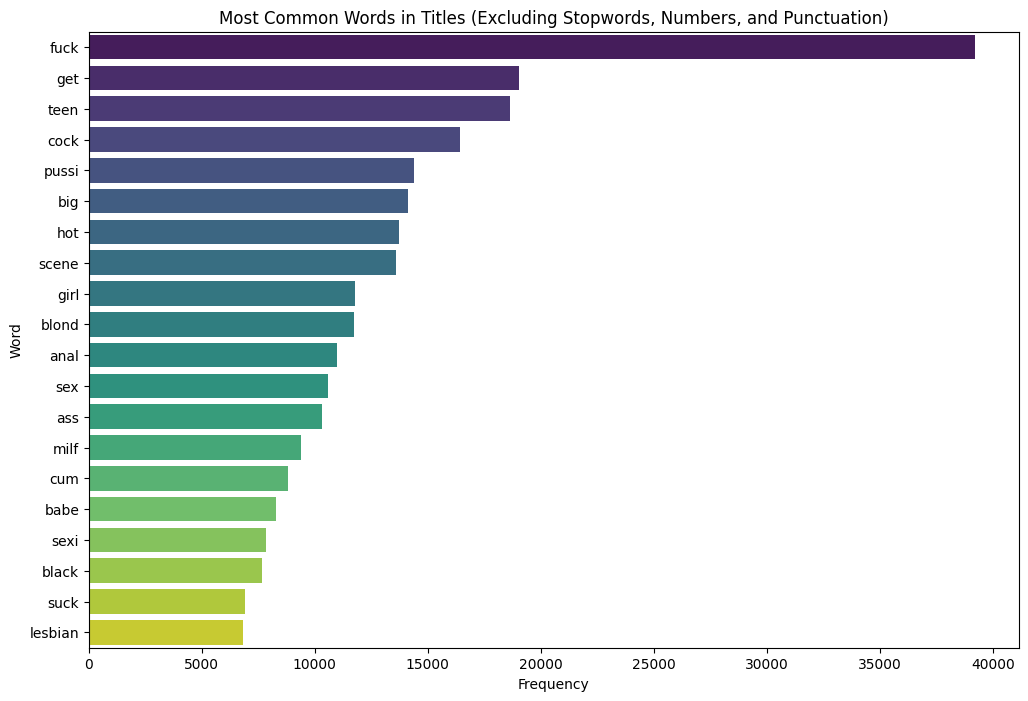

In [14]:
from src.models import embeddings

embeddings.download_nltk_data()

# Apply the function to the title column
df["title_words"] = df["title"].apply(embeddings.clean_tokenize_and_stem)

# Flatten the list of words and count frequencies
all_words = [word for words in df["title_words"] for word in words]
word_counts = Counter(all_words)

# Get the most common words
most_common_words = word_counts.most_common(20)

# Convert to DataFrame for plotting
word_freq_df = pd.DataFrame(most_common_words, columns=["word", "count"])

# Plot the most common words
plt.figure(figsize=(12, 8))
sns.barplot(x="count", y="word", data=word_freq_df, hue="word", palette="viridis")
plt.title("Most Common Words in Titles (Excluding Stopwords, Numbers, and Punctuation)")
plt.xlabel("Frequency")
plt.ylabel("Word")
output_plot_path = "plots/words_titles_frequency_distribution.png"
plt.savefig(output_plot_path, bbox_inches="tight")
plt.show()

#### Sentiment analysis


In [15]:
from textblob import TextBlob


# Function to calculate sentiment polarity
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity


# Apply the function to the title column
df["sentiment"] = df["title"].apply(get_sentiment)

# Plot the distribution of sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(df["sentiment"], bins=30, kde=True, color="skyblue")
plt.title("Sentiment Distribution of Titles")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Frequency")
output_plot_path = "plots/title_sentiment_distribution.png"
plt.savefig(output_plot_path, bbox_inches="tight")
plt.show()

# # Print some example titles with their sentiment scores
# print(df[["title", "sentiment"]].head(10))

ModuleNotFoundError: No module named 'textblob'

#### Identify most common adjacent pairs (n-grams)

Identify pairs of adjacent words in titles and see which are more prevalent in the dataset. N-grams capture more context than unigrams (single words) allowing for a better understandig of the relationship between words. They also allow to identify collocations (words that frequently appear together).


[nltk_data] Downloading package stopwords to /home/olga/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


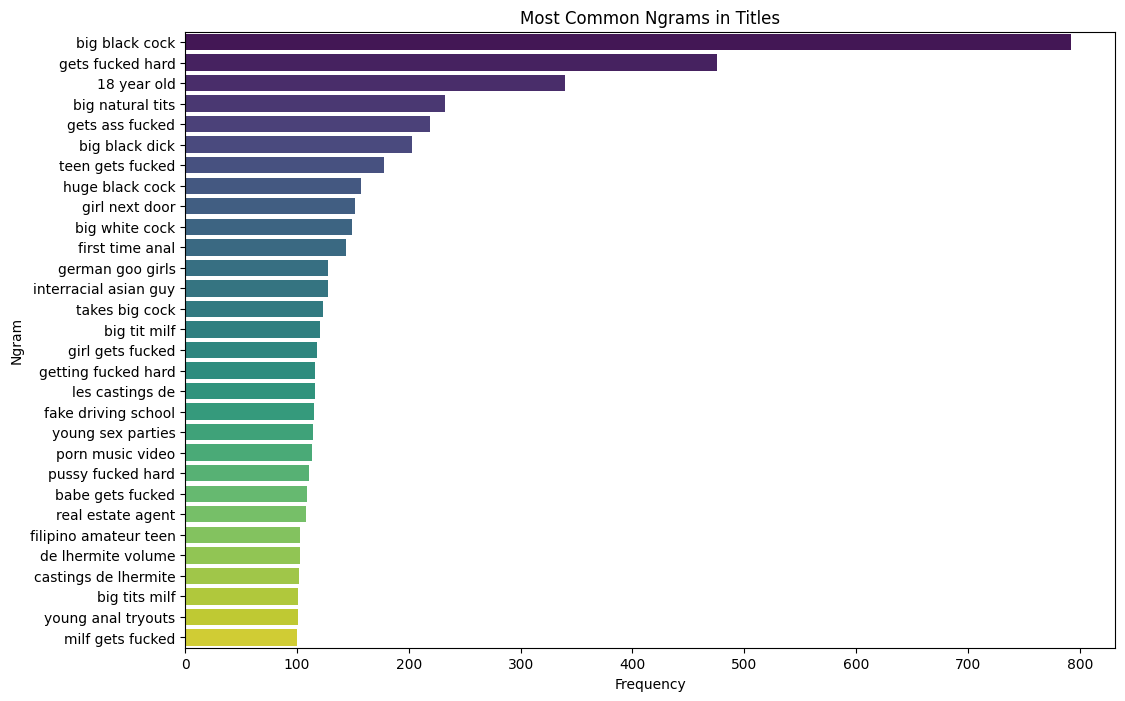

In [16]:
from nltk.util import ngrams
from src.models import embeddings

embeddings.download_nltk_data()

# Apply the function to the title column
df["title_words"] = df["title"].apply(embeddings.clean_and_tokenize)

# Generate bigrams
all_ngrams = [ngram for words in df["title_words"] for ngram in ngrams(words, 3)]

# Count the frequency of each bigram
ngram_counts = Counter(all_ngrams)

# Get the most common bigrams
most_common_ngrams = ngram_counts.most_common(30)

# Convert to DataFrame for plotting, converting bigrams to strings
ngram_freq_df = pd.DataFrame(most_common_ngrams, columns=["ngram", "count"])
ngram_freq_df["ngram"] = ngram_freq_df["ngram"].apply(lambda x: " ".join(x))

# Plot the most common bigrams
plt.figure(figsize=(12, 8))
sns.barplot(
    x="count",
    y="ngram",
    data=ngram_freq_df,
    hue="ngram",
    palette="viridis",
    legend=False,
)
plt.title("Most Common Ngrams in Titles")
plt.xlabel("Frequency")
plt.ylabel("Ngram")
output_plot_path = "plots/most_common_ngrams_frequency_distribution.png"
plt.savefig(output_plot_path, bbox_inches="tight")
plt.show()

In [ ]:
df.sentiment

0         0.250000
1         0.466667
2         0.000000
3         0.000000
4         0.125000
            ...   
217999   -0.362500
218000   -0.700000
218001    1.000000
218002   -0.500000
218003   -0.250000
Name: sentiment, Length: 218004, dtype: float64

In [ ]:
# here
df.popular_tags

0                          [Babe, Big Tits, Brunette, Teen]
1                           [Blowjob, Hardcore, MILF, Teen]
2         [Big Tits, Brunette, Cumshot, MILF, POV, Porns...
3                            [Amateur, Anal, Hardcore, POV]
4         [Amateur, Blonde, Brunette, Lesbian, Pornstar,...
                                ...                        
217999    [Amateur, Big Dick, Blowjob, Exclusive, Verifi...
218000    [Amateur, Anal, Exclusive, Masturbation, Verif...
218001    [Amateur, Anal, Exclusive, Masturbation, Toys,...
218002    [Amateur, Anal, Exclusive, Masturbation, Toys,...
218003    [Amateur, Anal, Cumshot, Exclusive, Verified A...
Name: popular_tags, Length: 218004, dtype: object

### 3. Grammatical analysis

- Indirect objects
- Active and passive subject, person or not e.g. body part
- adjective + subject What adjectives are more frequent with subjects e.g. hot chinese girl, and frequency distribution of adjectives and subjects
- context, place - in the shower, in the room, etc
- verbs frequency


In [ ]:
df = pd.read_csv("data/processed/dat.csv").head(10000)


import spacy

# Load the English NLP model
nlp = spacy.load("en_core_web_md")

# # TODO need more thinking
# # Function to extract indirect objects from a title
# def extract_indirect_object(title):
#     doc = nlp(title)
#     indirect_objects = []

#     for token in doc:
#         # Check for indirect object (dative case) or preposition followed by a noun
#         if token.dep_ == "iobj":
#             indirect_objects.append(token.text)
#         elif token.dep_ == "prep":  # Check for prepositions
#             # Look for the object of the preposition
#             for child in token.children:
#                 if child.dep_ in [
#                     "pobj",
#                     "dobj",
#                 ]:  # Object of the preposition or direct object
#                     indirect_objects.append(child.text)

#     return indirect_objects


# # Apply the function to the titles in the DataFrame
# df["indirect_object"] = df["title"].apply(extract_indirect_object)

# # Display the results
# df[["title", "indirect_object"]]


/home/olga/Documents/eur-porntypes/stereotype-map/venv/lib/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [17]:
# Subject active

import spacy

nlp = spacy.load("en_core_web_sm")


# Function to extract active subjects from a sentence
def extract_active_subjects(sentence):
    doc = nlp(sentence)
    subjects = []

    for token in doc:
        # Check for nominal subjects (nsubj) and compound subjects
        if token.dep_ == "nsubj":
            subjects.append(token.text)
        # Check for compound subjects
        elif token.dep_ == "nsubj" and token.head.dep_ == "ROOT":
            for child in token.children:
                if child.dep_ == "conj":  # Check for conjunctions
                    subjects.append(child.text)

    # Remove duplicates and return
    return list(set(subjects))


# Apply the function to the titles in the DataFrame
df["subject_active"] = df["title"].apply(extract_active_subjects)


ModuleNotFoundError: No module named 'spacy'

In [ ]:
# Function to extract passive subjects from a sentence
def extract_passive_subjects(sentence):
    doc = nlp(sentence)
    passive_subjects = []

    for token in doc:
        # Check if the token is a passive subject
        if token.dep_ == "nsubjpass":
            passive_subjects.append(token.text)
        # Additionally, check for auxiliary verbs that indicate passive voice
        elif token.dep_ == "auxpass":  # Auxiliary verb for passive voice
            # Check if the head of the auxiliary verb is a verb in passive form
            if token.head.dep_ == "VERB" and token.head.tag_ in [
                "VBN",
                "VBD",
            ]:  # VBN: past participle, VBD: past tense
                # Get the subject of the passive construction
                for child in token.head.children:
                    if child.dep_ == "nsubjpass":
                        passive_subjects.append(child.text)

    return passive_subjects


# Apply the function to the titles in the DataFrame
df["subject_pass"] = df["title"].apply(extract_passive_subjects)


In [ ]:
# df[["title", "subject_active", "subject_pass"]].sample(50)


In [ ]:
# Flatten the list of active subjects and lemmatize while normalizing case
all_active_subjects = []
for sublist in df["subject_active"]:
    for subject in sublist:
        doc = nlp(subject)  # Tokenize and lemmatize
        lemmatized_subjects = [
            token.lemma_.lower() for token in doc
        ]  # Get the lemmatized form and convert to lowercase
        all_active_subjects.extend(
            lemmatized_subjects
        )  # Add lemmatized subjects to the list

# Count the frequency of each subject
subject_frequency = Counter(all_active_subjects)

# Convert the frequency counts to a DataFrame
frequency_df = pd.DataFrame(subject_frequency.items(), columns=["Subject", "Frequency"])

# Sort the DataFrame by frequency in descending order
frequency_df = frequency_df.sort_values(by="Frequency", ascending=False)

# Save the frequency DataFrame to a CSV file
output_csv_path = "data/processed/active_subject_frequency_distribution.csv"
frequency_df.to_csv(output_csv_path, index=False)


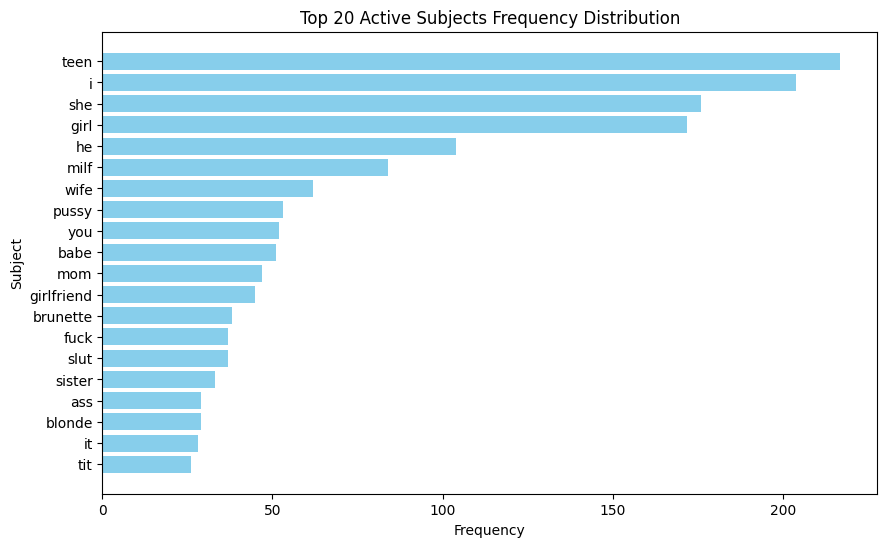

In [ ]:
# Create a bar chart for the top N subjects
top_n = 20  # Change this to the number of top subjects you want to visualize
plt.figure(figsize=(10, 6))
plt.barh(
    frequency_df["Subject"].head(top_n),
    frequency_df["Frequency"].head(top_n),
    color="skyblue",
)
plt.xlabel("Frequency")
plt.ylabel("Subject")
plt.title(f"Top {top_n} Active Subjects Frequency Distribution")
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency on top
output_plot_path = "plots/top_active_subjects_frequency_distribution.png"
plt.savefig(output_plot_path, bbox_inches="tight")
plt.show()


In [ ]:
# Flatten the list of passive subjects and lemmatize while normalizing case
all_passive_subjects = []
for sublist in df["subject_pass"]:
    for subject in sublist:
        doc = nlp(subject)  # Tokenize and lemmatize
        lemmatized_subjects = [token.lemma_.lower() for token in doc]
        all_passive_subjects.extend(lemmatized_subjects)

subject_frequency = Counter(all_passive_subjects)

frequency_df = pd.DataFrame(subject_frequency.items(), columns=["Subject", "Frequency"])

frequency_df = frequency_df.sort_values(by="Frequency", ascending=False)

# Save the frequency DataFrame to a CSV file
output_csv_path = "data/processed/passive_subject_frequency_distribution.csv"
frequency_df.to_csv(output_csv_path, index=False)


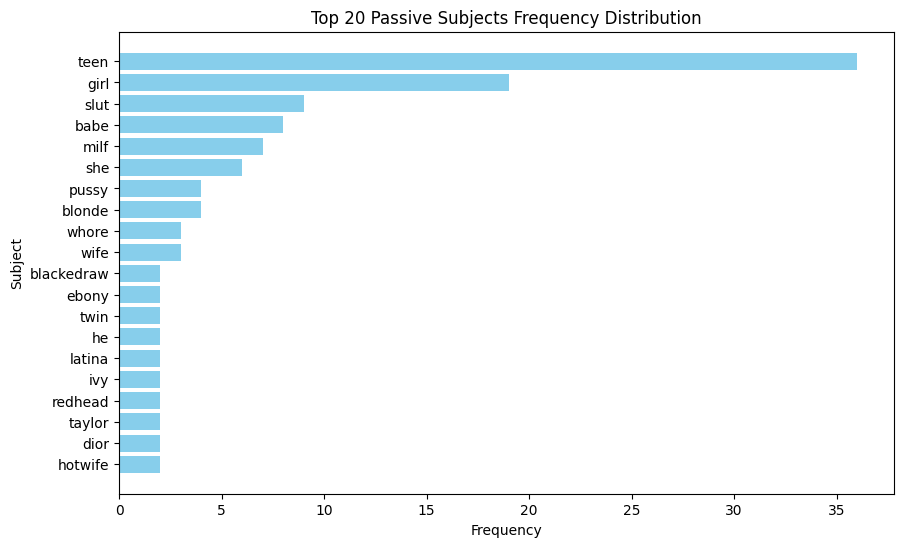

In [ ]:
# Create a bar chart for the top N subjects
top_n = 20

plt.figure(figsize=(10, 6))
plt.barh(
    frequency_df["Subject"].head(top_n),
    frequency_df["Frequency"].head(top_n),
    color="skyblue",
)
plt.xlabel("Frequency")
plt.ylabel("Subject")
plt.title(f"Top {top_n} Passive Subjects Frequency Distribution")
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency on top
output_plot_path = "plots/top_passive_subjects_frequency_distribution.png"
plt.savefig(output_plot_path, bbox_inches="tight")  # Save the figure with tight layout
plt.show()


In [ ]:
#### Context (in the room, on the chair etc)

In [ ]:
#### Adjective (freq distribution) + Subject, which adjectives are more frequent with subjects

In [ ]:
#### Verbs

In [ ]:
# save data to processed
output_path = "data/processed/dat.csv"
df.to_csv(output_path, index=False)
print(f"DataFrame saved to {output_path}")


DataFrame saved to data/processed/dat.csv


### 4. Generate embeddings

(Run on HPC)


In [ ]:
# TODO subset 10 rows
import pandas as pd
from src.utils import helpers

dat = df.head(20)

helpers.df_to_json(
    df=dat,
    key_col_name="url",
    value_col_name="popular_tags",
    filename="data/processed/video-tags.json",
)

helpers.df_to_json(
    df=dat,
    key_col_name="url",
    value_col_name="title_words",
    filename="data/processed/video-titles.json",
)


In [ ]:
# input data
STEREOTYPES_JSON_PATH = "data/processed/stereotypes.json"
TAGS_JSON_PATH = "data/processed/video-tags.json"
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v1"
# TODO try different models
# e.g. "bert-base-nli-mean-tokens"

embeddings.download_nltk_data()

# load stereotypes
stereotypes = embeddings.load_and_preprocess_data(STEREOTYPES_JSON_PATH)
tags = embeddings.load_and_preprocess_data(TAGS_JSON_PATH)


[nltk_data] Downloading package stopwords to /home/olga/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import transformers
import sentence_transformers
import torch

print(transformers.__version__)
print(sentence_transformers.__version__)
print(torch.__version__)


4.48.1
3.4.0
2.4.1+cu121


In [ ]:
stereotypes_emb = embeddings.generate_embeddings(stereotypes, MODEL_NAME)
# save stereotype embeddings
# TODO run for all and save results, long processing time
tags_emb = embeddings.generate_embeddings(tags, MODEL_NAME)

# save tag embeddings
# with open("tags_emb.pkl", "wb") as file:
#     pickle.dump(tags_emb, file)


2025-01-28 17:38:01,611 - INFO - Use pytorch device_name: cpu
2025-01-28 17:38:01,616 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v1
2025-01-28 17:38:03,167 - INFO - Use pytorch device_name: cpu
2025-01-28 17:38:03,167 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v1


{'66b7ebb62b2': [0.02995031327009201,
  0.0778464749455452,
  0.06500343978404999,
  -0.007316527888178825,
  -0.06642275303602219,
  0.0842486247420311,
  0.08051371574401855,
  -0.0783928781747818,
  -0.03797760233283043,
  -0.031912680715322495,
  -0.01448563951998949,
  -0.03800039365887642,
  -0.040882982313632965,
  -0.007559430785477161,
  -0.0832599475979805,
  0.05261654779314995,
  0.01772661879658699,
  0.0004051036958117038,
  -0.0669177696108818,
  -0.15116262435913086,
  0.050791461020708084,
  0.019002458080649376,
  -0.05158606171607971,
  0.09042680263519287,
  -0.04294281825423241,
  -0.00047009793343022466,
  0.0006112278206273913,
  -0.02893671952188015,
  0.15049292147159576,
  -0.050932206213474274,
  0.03762158751487732,
  0.03006519377231598,
  0.011534943245351315,
  -0.04319695755839348,
  0.01655454747378826,
  -0.024245815351605415,
  -0.02597532980144024,
  0.028262976557016373,
  -0.005300565157085657,
  -0.018878964707255363,
  -0.01375886145979166,
  -0.

In [ ]:
# Calculate similarity between tags and stereotypes
sim_df = embeddings.calculate_similarity(tags_emb, stereotypes_emb)

In [ ]:
sim_df

,SubWhW,AggresBlM,LargeBlW,AggresM,AsianW,Taboo,LargeBreastWhW
66b7ebb62b2,0.122358,0.202808,0.117540,0.206358,0.051880,0.077672,0.077938
6dec53bcd75,0.171131,0.186486,0.162821,0.194901,0.062692,0.134109,0.095554
2b899bc1cc4,0.156481,0.196191,0.098803,0.190418,0.037654,0.040720,0.067401
0e16e823b7b,0.140139,0.177960,0.123555,0.153415,0.090801,0.092861,0.080241
db2b89b88fc,0.127115,0.154199,0.064939,0.115271,0.069447,0.123047,0.081020
f79b2e2fb88,0.168546,0.165461,0.120012,0.167419,0.102488,0.122855,0.114725
1075c5e2d90,0.166664,0.172176,0.087096,0.186548,0.038985,0.013704,0.056830
66da4b21205,0.191487,0.171504,0.120963,0.144058,0.093172,0.127390,0.096874
bbcc9f0c953,0.168856,0.228910,0.118859,0.178726,0.086836,0.088207,0.091983
c1d6fe13a96,0.198531,0.142562,0.109261,0.152341,0.055521,0.105114,0.071060


### 4. Similarity matrix


In [ ]:
# import src.visualization.plot_heatmap as plot_heatmap

# plot_heatmap.plot_heatmap(sim_df, "heatmap", model_name=MODEL_NAME)
# extract top 3 stereotypes for each video
# create df with extra column 'stereotype1', 'stereotype2', etc

### 7. Network graph


In [ ]:
# import src.visualization.create_network_graph as create_network_graph

# create_network_graph.create_network_graph(
#     tags, stereotypes, sim_df, "network_graph", model_name=MODEL_NAME
# )
# Analyse patterns of connections between Videos (tags?) and Stereotypes​
# Degree distribution​

# Community detection and clustering​